<a href="https://colab.research.google.com/github/vinnichowdary/ImageClassifier/blob/main/Petal_to_Metal_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, ReLU, DepthwiseConv2D, Conv2D, Input
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib import pyplot as plt

In [ ]:
IMAGE_SIZE = 192
BATCH_SIZE = 32
GCS_DS_PATH = '/content/drive/MyDrive/Dataset'
GCS_PATH = GCS_DS_PATH + f"/tfrecords-jpeg-{IMAGE_SIZE}x{IMAGE_SIZE}"
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/train/*.tfrec")
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/val/*.tfrec")
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/test/*.tfrec")

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, tf.one_hot(label, len(CLASSES)) # returns a dataset of (image, label) pairs


def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)


def load_dataset(filenames, labeled: bool = True, ordered: bool = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset


def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.9)
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    return image, label


def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset


def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset


def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset


def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    return sum(int(re.search(r"-([0-9]*)\.", x).group(1)) for x in filenames)


In [ ]:
#loading the models
def get_pretrained_model():
    backbone = tf.keras.applications.MobileNetV2(  # Pretrained MobileNetV2
        include_top=False,
        weights="imagenet",
        input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3],
    )
    model = tf.keras.models.Sequential(
        [
            backbone,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation="softmax"),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

def depthwise_separable_conv_block(inputs, pointwise_conv_filters, alpha=1.0, depth_multiplier=1, strides=1):
    depthwise_conv_filters = int(pointwise_conv_filters * alpha)
    x = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=depth_multiplier, strides=strides)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(pointwise_conv_filters, (1, 1), padding='same', strides=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def create_mobilenetv2_model(input_shape, num_classes, alpha=1.0, depth_multiplier=1):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = depthwise_separable_conv_block(x, 64, alpha, depth_multiplier)
    x = depthwise_separable_conv_block(x, 128, alpha, depth_multiplier, strides=2)
    x = depthwise_separable_conv_block(x, 128, alpha, depth_multiplier)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs, x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

def get_mobilenetv2_scratch_model():
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    num_classes = len(CLASSES)
    alpha = 1.0
    model = create_mobilenetv2_model(input_shape, num_classes, alpha)
    return model


In [ ]:
num_training_images = count_data_items(TRAINING_FILENAMES)
num_validation_images = count_data_items(VALIDATION_FILENAMES)
num_test_images = count_data_items(TEST_FILENAMES)

print(f"Number of training images:   {num_training_images:,d}.")
print(f"Number of validation images: {num_validation_images:,d}.")
print(f"Number of testing images:    {num_test_images:,d}.")

train_dataset = get_training_dataset()
val_dataset = get_validation_dataset()
test_dataset = get_test_dataset(ordered=True)

Number of training images:   12,753.
Number of validation images: 3,712.
Number of testing images:    7,382.


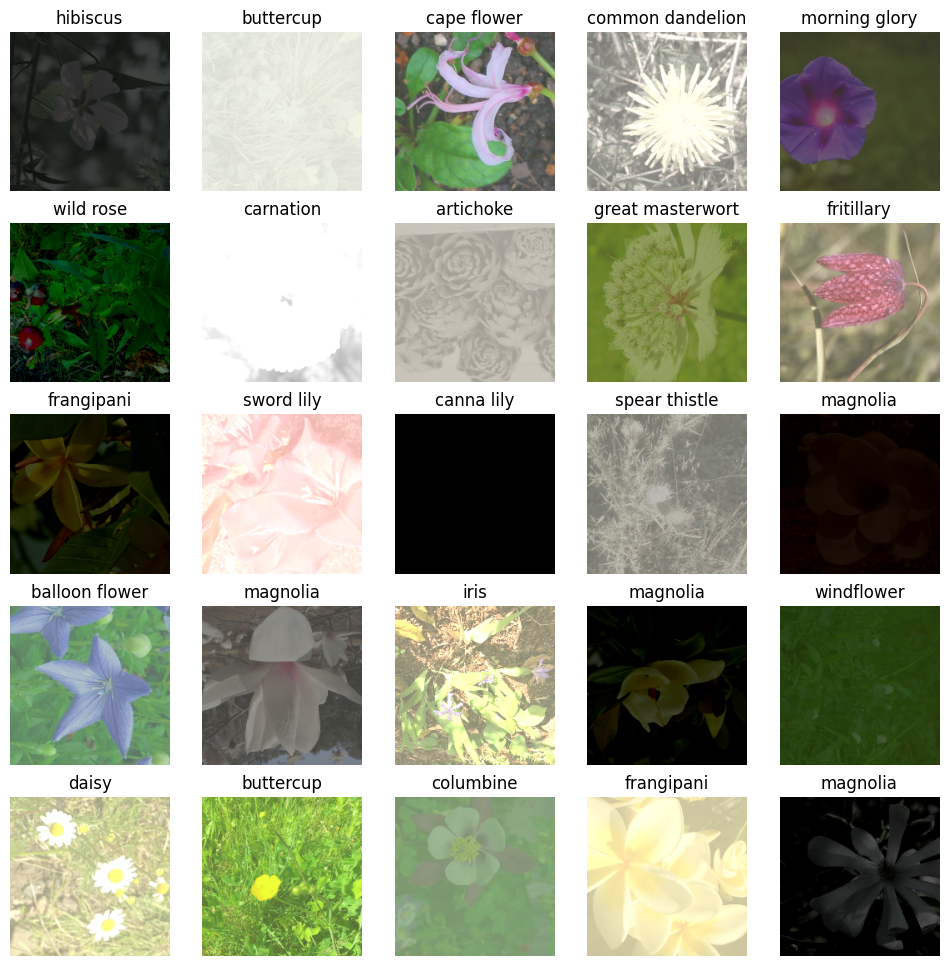

In [ ]:
figure, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = [y for x in axes for y in x]

for i, sample in enumerate(train_dataset.unbatch().take(25).as_numpy_iterator()):
    axes[i].imshow(sample[0])

    flower_type = CLASSES[tf.argmax(sample[1]).numpy()]
    axes[i].set_title(flower_type)
    axes[i].axis('off')


In [ ]:
pretrained_model  = get_pretrained_model()
pretrained_model .summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 104)               133224    
                                                                 
Total params: 2391208 (9.12 MB)
Trainable params: 2357096 (8.99 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [ ]:
mobilenetv2_scratch_model   = get_mobilenetv2_scratch_model()
mobilenetv2_scratch_model .summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 96, 96, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 96, 96, 32)        320       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 96, 96, 32)        128   

In [ ]:
# Train the MobileNetV2 model built from scratch
mobilenetv2_scratch_history = mobilenetv2_scratch_model.fit(
    get_training_dataset(),
    validation_data=get_validation_dataset(),
    epochs=40,
    steps_per_epoch=num_training_images // BATCH_SIZE,
    validation_steps=num_validation_images // BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "mobilenetv2_scratch_model.h5",
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True,
            verbose=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            mode='max',
            patience=5,
            min_lr=1e-6,
            verbose=2,
        ),
    ],
    verbose=2,
).history

Epoch 1/40

Epoch 1: val_accuracy improved from -inf to 0.04203, saving model to mobilenetv2_scratch_model.h5
398/398 - 55s - loss: 4.4052 - accuracy: 0.0555 - val_loss: 4.4290 - val_accuracy: 0.0420 - lr: 1.0000e-04 - 55s/epoch - 139ms/step
Epoch 2/40

Epoch 2: val_accuracy improved from 0.04203 to 0.12742, saving model to mobilenetv2_scratch_model.h5
398/398 - 33s - loss: 4.0388 - accuracy: 0.0971 - val_loss: 3.8539 - val_accuracy: 0.1274 - lr: 1.0000e-04 - 33s/epoch - 82ms/step
Epoch 3/40

Epoch 3: val_accuracy did not improve from 0.12742
398/398 - 29s - loss: 3.9124 - accuracy: 0.1020 - val_loss: 3.7830 - val_accuracy: 0.1274 - lr: 1.0000e-04 - 29s/epoch - 72ms/step
Epoch 4/40

Epoch 4: val_accuracy improved from 0.12742 to 0.13120, saving model to mobilenetv2_scratch_model.h5
398/398 - 35s - loss: 3.8556 - accuracy: 0.1058 - val_loss: 3.7344 - val_accuracy: 0.1312 - lr: 1.0000e-04 - 35s/epoch - 87ms/step
Epoch 5/40

Epoch 5: val_accuracy improved from 0.13120 to 0.14224, saving m

In [ ]:
# Train the pretrained MobileNetV2 model
pretrained_history = pretrained_model.fit(
    get_training_dataset(),
    validation_data=get_validation_dataset(),
    epochs=40,
    steps_per_epoch=num_training_images // BATCH_SIZE,
    validation_steps=num_validation_images // BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "pretrained_model.h5",
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True,
            verbose=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            mode='max',
            patience=5,
            min_lr=1e-6,
            verbose=2,
        ),
    ],
    verbose=2,
).history

Epoch 1/40

Epoch 1: val_accuracy improved from -inf to 0.48545, saving model to pretrained_model.h5
398/398 - 80s - loss: 2.4523 - accuracy: 0.4437 - val_loss: 2.0068 - val_accuracy: 0.4855 - lr: 1.0000e-04 - 80s/epoch - 201ms/step
Epoch 2/40

Epoch 2: val_accuracy improved from 0.48545 to 0.68373, saving model to pretrained_model.h5
398/398 - 48s - loss: 1.1179 - accuracy: 0.7162 - val_loss: 1.1875 - val_accuracy: 0.6837 - lr: 1.0000e-04 - 48s/epoch - 120ms/step
Epoch 3/40

Epoch 3: val_accuracy improved from 0.68373 to 0.77290, saving model to pretrained_model.h5
398/398 - 49s - loss: 0.7830 - accuracy: 0.7951 - val_loss: 0.8436 - val_accuracy: 0.7729 - lr: 1.0000e-04 - 49s/epoch - 124ms/step
Epoch 4/40

Epoch 4: val_accuracy improved from 0.77290 to 0.79714, saving model to pretrained_model.h5
398/398 - 48s - loss: 0.6079 - accuracy: 0.8388 - val_loss: 0.7631 - val_accuracy: 0.7971 - lr: 1.0000e-04 - 48s/epoch - 120ms/step
Epoch 5/40

Epoch 5: val_accuracy improved from 0.79714 to 

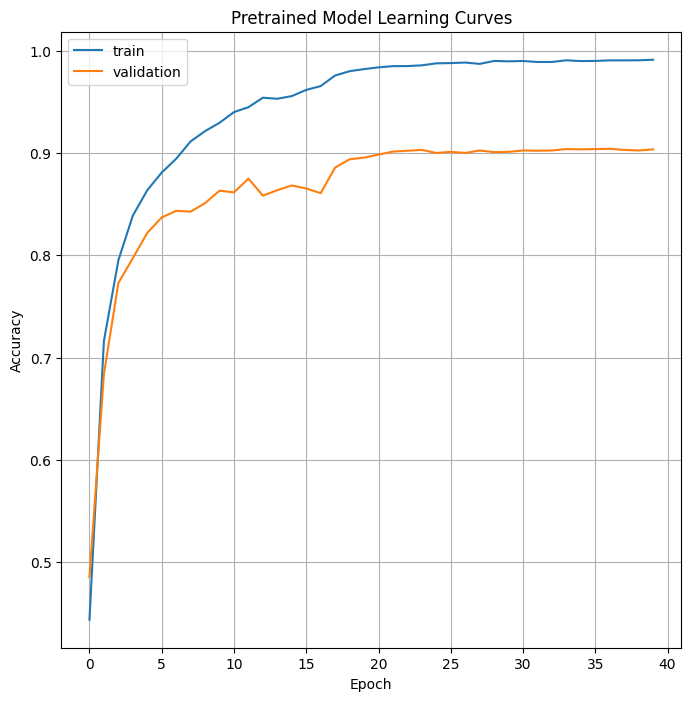

In [ ]:
# Plot the learning curves for the pretrained model
figure, axes = plt.subplots(1, 1, figsize=(8, 8))
epochs = list(range(len(pretrained_history["loss"])))
axes.plot(epochs, pretrained_history["accuracy"], label="train")
axes.plot(epochs, pretrained_history["val_accuracy"], label="validation")
axes.set_title("Pretrained Model Learning Curves")
axes.set_xlabel("Epoch")
axes.set_ylabel("Accuracy")
axes.legend()
axes.grid()

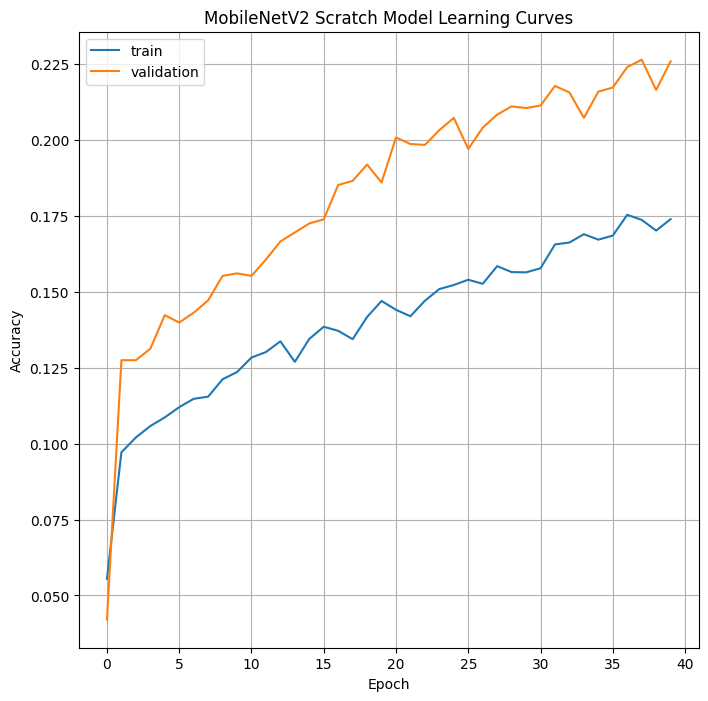

In [ ]:
# Plot the learning curves for the MobileNetV2 scratch model
figure, axes = plt.subplots(1, 1, figsize=(8, 8))
epochs = list(range(len(mobilenetv2_scratch_history["loss"])))
axes.plot(epochs, mobilenetv2_scratch_history["accuracy"], label="train")
axes.plot(epochs, mobilenetv2_scratch_history["val_accuracy"], label="validation")
axes.set_title("MobileNetV2 Scratch Model Learning Curves")
axes.set_xlabel("Epoch")
axes.set_ylabel("Accuracy")
axes.legend()
axes.grid()